In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
cassandra_file = '/content/tpcds_cassandra_sf1.txt'
mongodb_file = '/content/tpcds_mongodb_sf1.txt'
postgresql_file = '/content/tpcds_postgresql_sf1.txt'

# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read the data
cassandra_data = pd.read_csv(cassandra_file, sep=r'\s+', names=columns, skiprows=1)
mongodb_data = pd.read_csv(mongodb_file, sep=r'\s+', names=columns, skiprows=1)
postgresql_data = pd.read_csv(postgresql_file, sep=r'\s+', names=columns, skiprows=1)

# Add a database column
cassandra_data["database"] = "Cassandra"
mongodb_data["database"] = "MongoDB"
postgresql_data["database"] = "PostgreSQL"

# Combine data
combined_data = pd.concat([cassandra_data, mongodb_data, postgresql_data])

# Filter out failed queries
combined_data = combined_data[combined_data['status'] == 'pass']

# Convert relevant columns to numeric
metrics = ["wallTimeP50", "processCpuTimeP50", "queryCpuTimeP50"]
combined_data[metrics] = combined_data[metrics].apply(pd.to_numeric, errors='coerce')

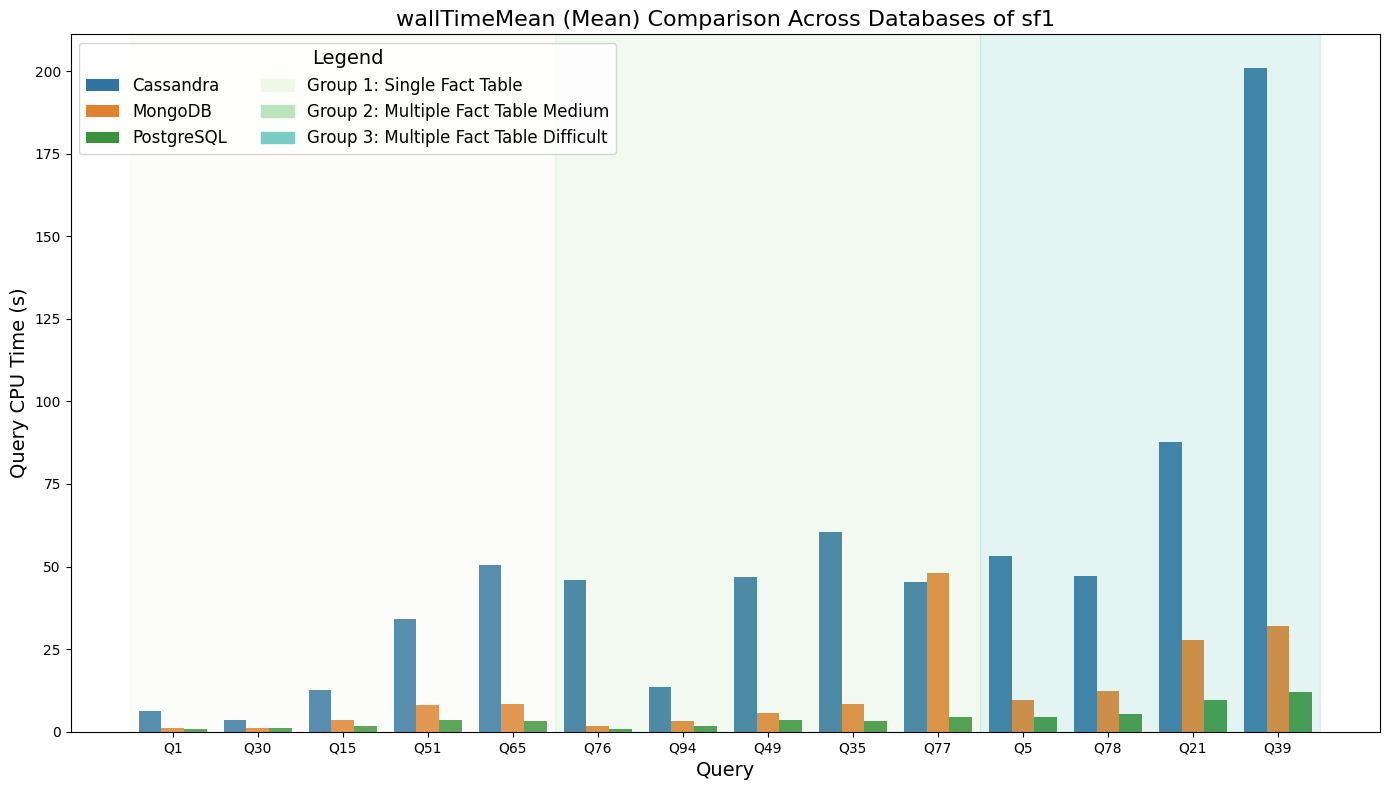

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define query groups
group_mapping = {
    "Q1": "Group 1: Single Fact Table",
    "Q30": "Group 1: Single Fact Table",
    "Q15": "Group 1: Single Fact Table",
    "Q51": "Group 1: Single Fact Table",
    "Q65": "Group 1: Single Fact Table",
    "Q76": "Group 2: Multiple Fact Table Medium",
    "Q94": "Group 2: Multiple Fact Table Medium",
    "Q49": "Group 2: Multiple Fact Table Medium",
    "Q35": "Group 2: Multiple Fact Table Medium",
    "Q77": "Group 2: Multiple Fact Table Medium",
    "Q5": "Group 3: Multiple Fact Table Difficult",
    "Q78": "Group 3: Multiple Fact Table Difficult",
    "Q21": "Group 3: Multiple Fact Table Difficult",
    "Q39": "Group 3: Multiple Fact Table Difficult",
}

# Add group information to the data
combined_data_s = combined_data.copy()
combined_data_s[metrics + ["wallTimeMean"]] = combined_data[metrics + ["wallTimeMean"]].apply(pd.to_numeric, errors='coerce') / 1000
combined_data_s["group"] = combined_data_s["query"].map(group_mapping)

# Set query order based on groups
query_order = sorted(combined_data_s["query"].unique(), key=lambda q: list(group_mapping.keys()).index(q))

# Define group colors (only once)
group_colors = {
    "Group 1: Single Fact Table": "#f0f9e8",
    "Group 2: Multiple Fact Table Medium": "#bae4bc",
    "Group 3: Multiple Fact Table Difficult": "#7bccc4",
}

# Plot wallTimeMean comparison
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=combined_data_s,
    x="query",
    y="wallTimeMean",
    hue="database",
    order=query_order,
)
ax.set_title("wallTimeMean (Mean) Comparison Across Databases of sf1", fontsize=16)
ax.set_ylabel("Query CPU Time (s)", fontsize=14)
ax.set_xlabel("Query", fontsize=14)

# Add group separation as background shading
current_x = 0
for group, color in group_colors.items():
    queries_in_group = [
        q for q, grp in group_mapping.items() if grp == group
    ]
    num_bars = len(queries_in_group)
    plt.axvspan(current_x - 0.5, current_x + num_bars - 0.5, color=color, alpha=0.2)
    current_x += num_bars

# Create the legend for the `hue` (database) values
handles_db, labels_db = ax.get_legend_handles_labels()

# Create the legend for the group colors (background)
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]

# Combine the two legends into one
plt.legend(
    handles=handles_db + group_patches,
    labels=labels_db + list(group_colors.keys()),
    bbox_to_anchor=(0, 1),  # Positioning the legend inside the plot (top-left)
    loc="upper left",  # Top-left corner
    title="Legend",
    fontsize=12,
    title_fontsize=14,
    ncol=2  # Display the group colors in 2 columns
)

# Adjust layout to ensure everything fits and legend doesn't overlap
plt.tight_layout()
plt.show()

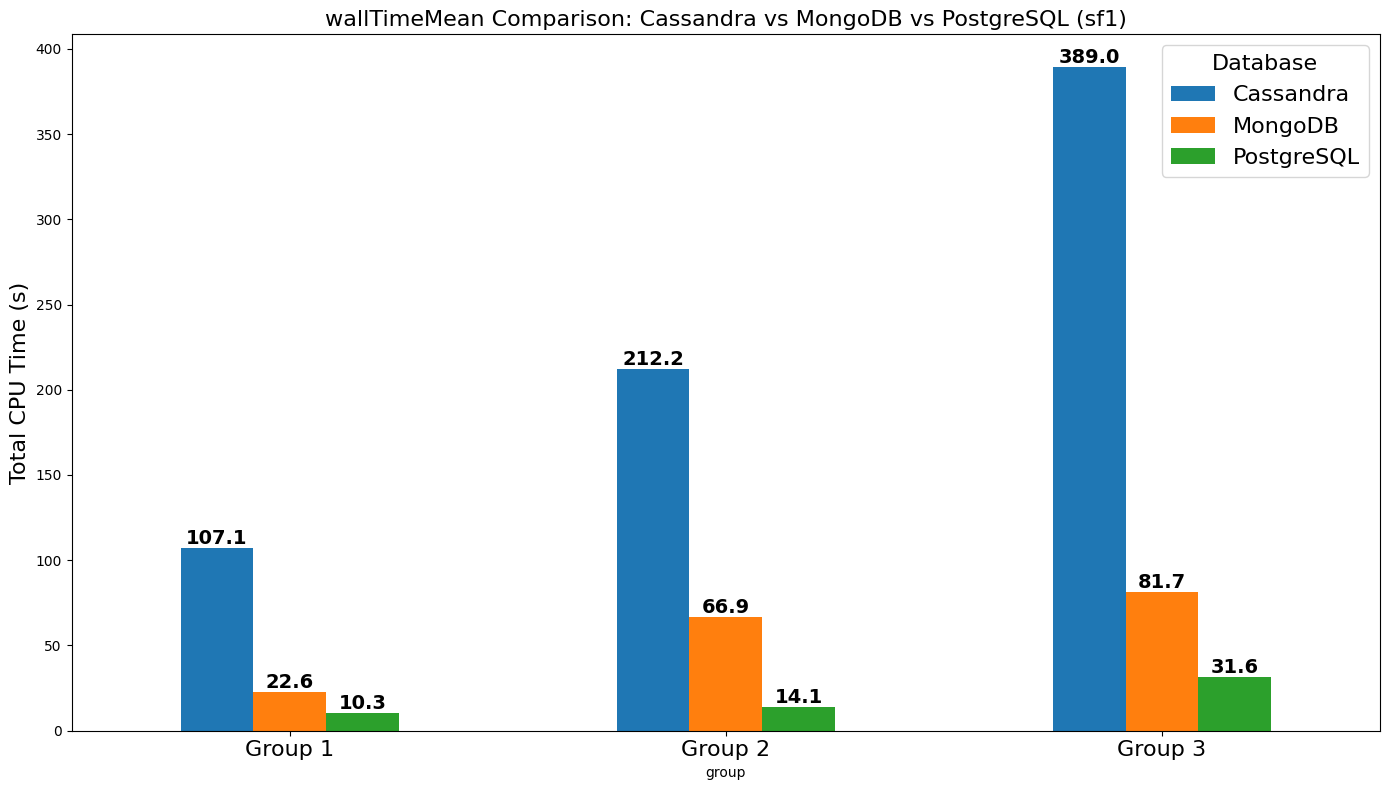

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
cassandra_file = '/content/tpcds_cassandra_sf1.txt'
mongodb_file = '/content/tpcds_mongodb_sf1.txt'
postgresql_file = '/content/tpcds_postgresql_sf1.txt'

# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read and process the data
data = pd.concat([
    pd.read_csv(cassandra_file, sep=r'\s+', names=columns, skiprows=1).assign(database="Cassandra"),
    pd.read_csv(mongodb_file, sep=r'\s+', names=columns, skiprows=1).assign(database="MongoDB"),
    pd.read_csv(postgresql_file, sep=r'\s+', names=columns, skiprows=1).assign(database="PostgreSQL"),
])

# Filter out failed queries and convert wallTimeMean to seconds
data = data[data['status'] == 'pass']
data["wallTimeMean"] = pd.to_numeric(data["wallTimeMean"], errors='coerce') / 1000

# Map queries to groups
group_mapping = {
    "Q1": "Group 1", "Q30": "Group 1", "Q15": "Group 1", "Q51": "Group 1", "Q65": "Group 1",
    "Q76": "Group 2", "Q94": "Group 2", "Q49": "Group 2", "Q35": "Group 2", "Q77": "Group 2",
    "Q5": "Group 3", "Q78": "Group 3", "Q21": "Group 3", "Q39": "Group 3"
}
data['group'] = data['query'].map(group_mapping)

# Group data by group and database, summing wallTimeMean
grouped_data = data.groupby(['group', 'database'], as_index=False)['wallTimeMean'].sum()

# Pivot the data to structure it for side-by-side bars
pivoted_data = grouped_data.pivot(index='group', columns='database', values='wallTimeMean').fillna(0)

# Plot the bars side by side (matplotlib will use default colors)
ax = pivoted_data.plot(kind="bar", figsize=(14, 8))

# Add numerical labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
plt.title("wallTimeMean Comparison: Cassandra vs MongoDB vs PostgreSQL (sf1)", fontsize=16)
plt.ylabel("Total CPU Time (s)", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=16)
plt.legend(title="Database", fontsize=16, title_fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

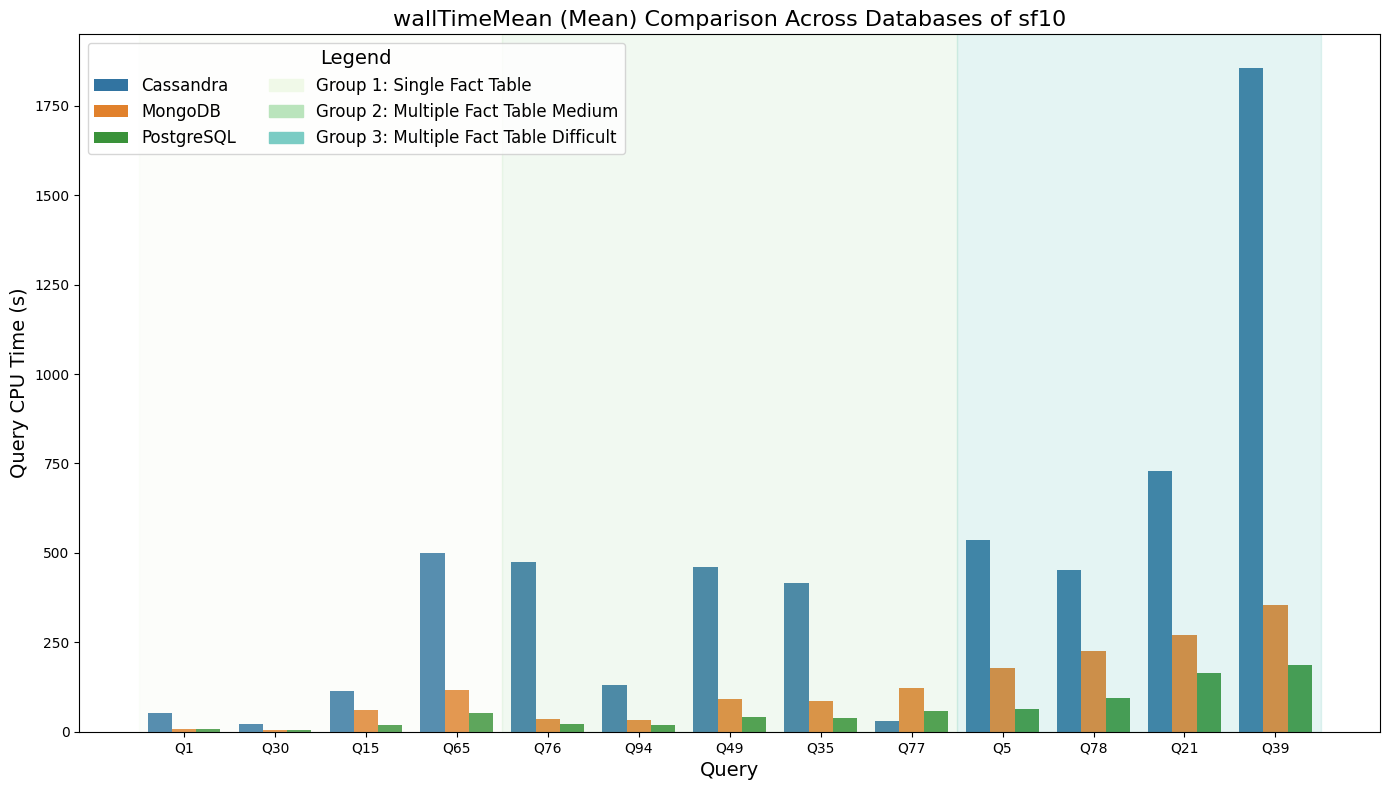

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# File paths for sf10
cassandra_file = '/content/tpcds_cassandra_sf10.txt'
mongodb_file = '/content/tpcds_mongodb_sf10.txt'
postgresql_file = '/content/tpcds_postgresql_sf10.txt'

# Define column names (matching your data format)
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read the data for sf10
cassandra_data = pd.read_csv(cassandra_file, sep=r'\s+', names=columns, skiprows=1)
mongodb_data = pd.read_csv(mongodb_file, sep=r'\s+', names=columns, skiprows=1)
postgresql_data = pd.read_csv(postgresql_file, sep=r'\s+', names=columns, skiprows=1)

# Add a database column
cassandra_data["database"] = "Cassandra"
mongodb_data["database"] = "MongoDB"
postgresql_data["database"] = "PostgreSQL"

# Combine the data
combined_data = pd.concat([cassandra_data, mongodb_data, postgresql_data])

# Filter out failed queries
combined_data = combined_data[combined_data['status'] == 'pass']

# Convert relevant columns to numeric
metrics = ["wallTimeP50", "processCpuTimeP50", "queryCpuTimeP50"]
combined_data[metrics] = combined_data[metrics].apply(pd.to_numeric, errors='coerce')

# Define query groups for sf10 (same groups as before, adjust if needed)
group_mapping = {
    "Q1": "Group 1: Single Fact Table",
    "Q30": "Group 1: Single Fact Table",
    "Q15": "Group 1: Single Fact Table",
    # "Q51": "Group 1: Single Fact Table",
    "Q65": "Group 1: Single Fact Table",
    "Q76": "Group 2: Multiple Fact Table Medium",
    "Q94": "Group 2: Multiple Fact Table Medium",
    "Q49": "Group 2: Multiple Fact Table Medium",
    "Q35": "Group 2: Multiple Fact Table Medium",
    "Q77": "Group 2: Multiple Fact Table Medium",
    "Q5": "Group 3: Multiple Fact Table Difficult",
    "Q78": "Group 3: Multiple Fact Table Difficult",
    "Q21": "Group 3: Multiple Fact Table Difficult",
    "Q39": "Group 3: Multiple Fact Table Difficult",
}

# Add group information to the data for sf10
combined_data_s = combined_data.copy()
combined_data_s[metrics + ["wallTimeMean"]] = combined_data[metrics + ["wallTimeMean"]].apply(pd.to_numeric, errors='coerce') / 1000
combined_data_s["group"] = combined_data_s["query"].map(group_mapping)

# Set query order based on groups for sf10
query_order = sorted(combined_data_s["query"].unique(), key=lambda q: list(group_mapping.keys()).index(q))

# Define group colors (same as before)
group_colors = {
    "Group 1: Single Fact Table": "#f0f9e8",
    "Group 2: Multiple Fact Table Medium": "#bae4bc",
    "Group 3: Multiple Fact Table Difficult": "#7bccc4",
}

# Plot wallTimeMean comparison for sf10
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=combined_data_s,
    x="query",
    y="wallTimeMean",
    hue="database",
    order=query_order,
)
ax.set_title("wallTimeMean (Mean) Comparison Across Databases of sf10", fontsize=16)
ax.set_ylabel("Query CPU Time (s)", fontsize=14)
ax.set_xlabel("Query", fontsize=14)

# Add group separation as background shading for sf10
current_x = 0
for group, color in group_colors.items():
    queries_in_group = [
        q for q, grp in group_mapping.items() if grp == group
    ]
    num_bars = len(queries_in_group)
    # Adjust the position to make sure we separate each group correctly
    plt.axvspan(current_x - 0.5, current_x + num_bars - 0.5, color=color, alpha=0.2)
    current_x += num_bars  # Move current_x to the next group start

# Create the legend for the `hue` (database) values
handles_db, labels_db = ax.get_legend_handles_labels()

# Create the legend for the group colors (background)
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]

# Combine the two legends into one
plt.legend(
    handles=handles_db + group_patches,
    labels=labels_db + list(group_colors.keys()),
    bbox_to_anchor=(0, 1),  # Positioning the legend inside the plot (top-left)
    loc="upper left",  # Top-left corner
    title="Legend",
    fontsize=12,
    title_fontsize=14,
    ncol=2  # Display the group colors in 2 columns
)

# Adjust layout to ensure everything fits and legend doesn't overlap
plt.tight_layout()
plt.show()

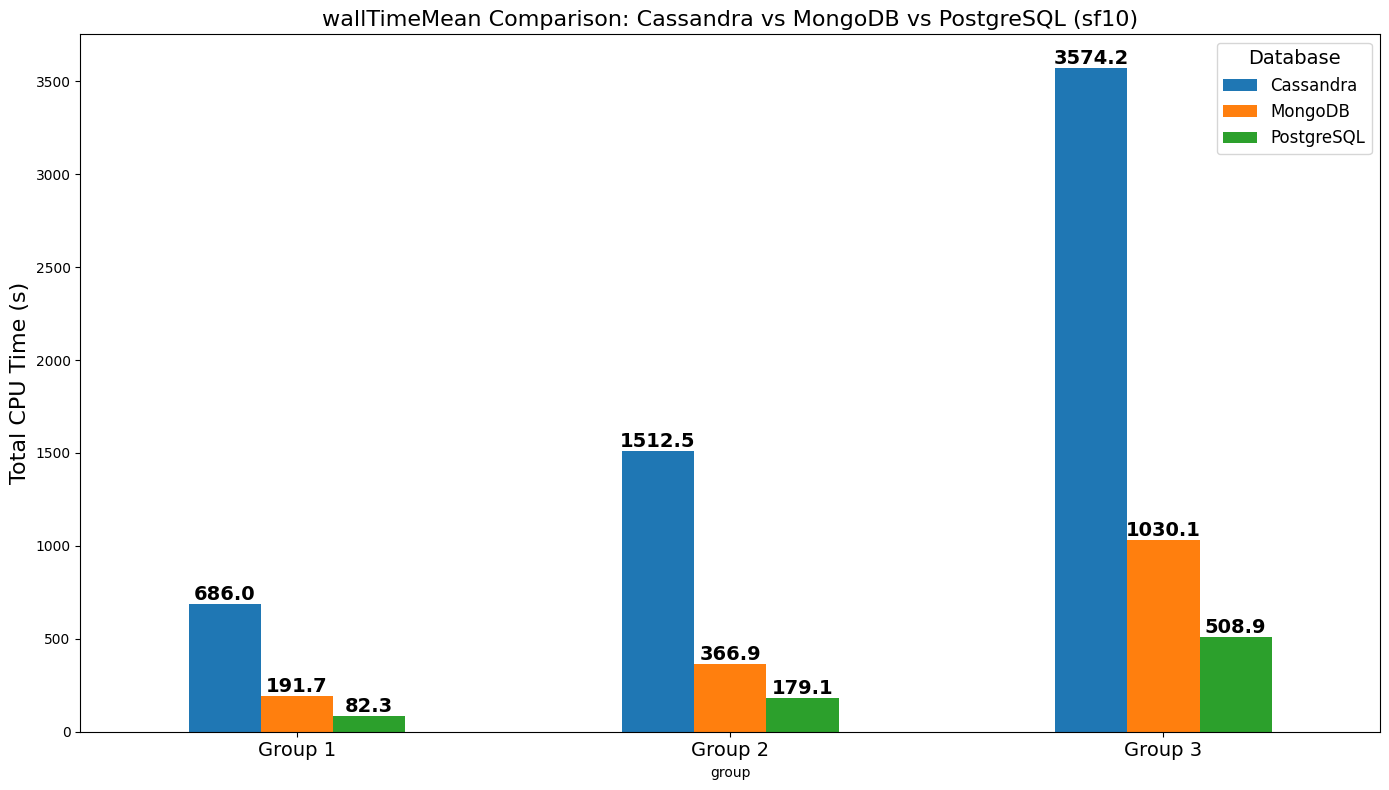

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
cassandra_file = '/content/tpcds_cassandra_sf10.txt'
mongodb_file = '/content/tpcds_mongodb_sf10.txt'
postgresql_file = '/content/tpcds_postgresql_sf10.txt'

# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read and process the data
data = pd.concat([
    pd.read_csv(cassandra_file, sep=r'\s+', names=columns, skiprows=1).assign(database="Cassandra"),
    pd.read_csv(mongodb_file, sep=r'\s+', names=columns, skiprows=1).assign(database="MongoDB"),
    pd.read_csv(postgresql_file, sep=r'\s+', names=columns, skiprows=1).assign(database="PostgreSQL"),
])

# Filter out failed queries and convert wallTimeMean to seconds
data = data[data['status'] == 'pass']
data["wallTimeMean"] = pd.to_numeric(data["wallTimeMean"], errors='coerce') / 1000

# Map queries to groups
group_mapping = {
    "Q1": "Group 1", "Q30": "Group 1", "Q15": "Group 1", "Q51": "Group 1", "Q65": "Group 1",
    "Q76": "Group 2", "Q94": "Group 2", "Q49": "Group 2", "Q35": "Group 2", "Q77": "Group 2",
    "Q5": "Group 3", "Q78": "Group 3", "Q21": "Group 3", "Q39": "Group 3"
}
data['group'] = data['query'].map(group_mapping)

# Group data by group and database, summing wallTimeMean
grouped_data = data.groupby(['group', 'database'], as_index=False)['wallTimeMean'].sum()

# Pivot the data to structure it for side-by-side bars
pivoted_data = grouped_data.pivot(index='group', columns='database', values='wallTimeMean').fillna(0)

# Plot the bars side by side (matplotlib will use default colors)
ax = pivoted_data.plot(kind="bar", figsize=(14, 8))

# Add numerical labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
plt.title("wallTimeMean Comparison: Cassandra vs MongoDB vs PostgreSQL (sf10)", fontsize=16)
plt.ylabel("Total CPU Time (s)", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=14)
plt.legend(title="Database", fontsize=12, title_fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

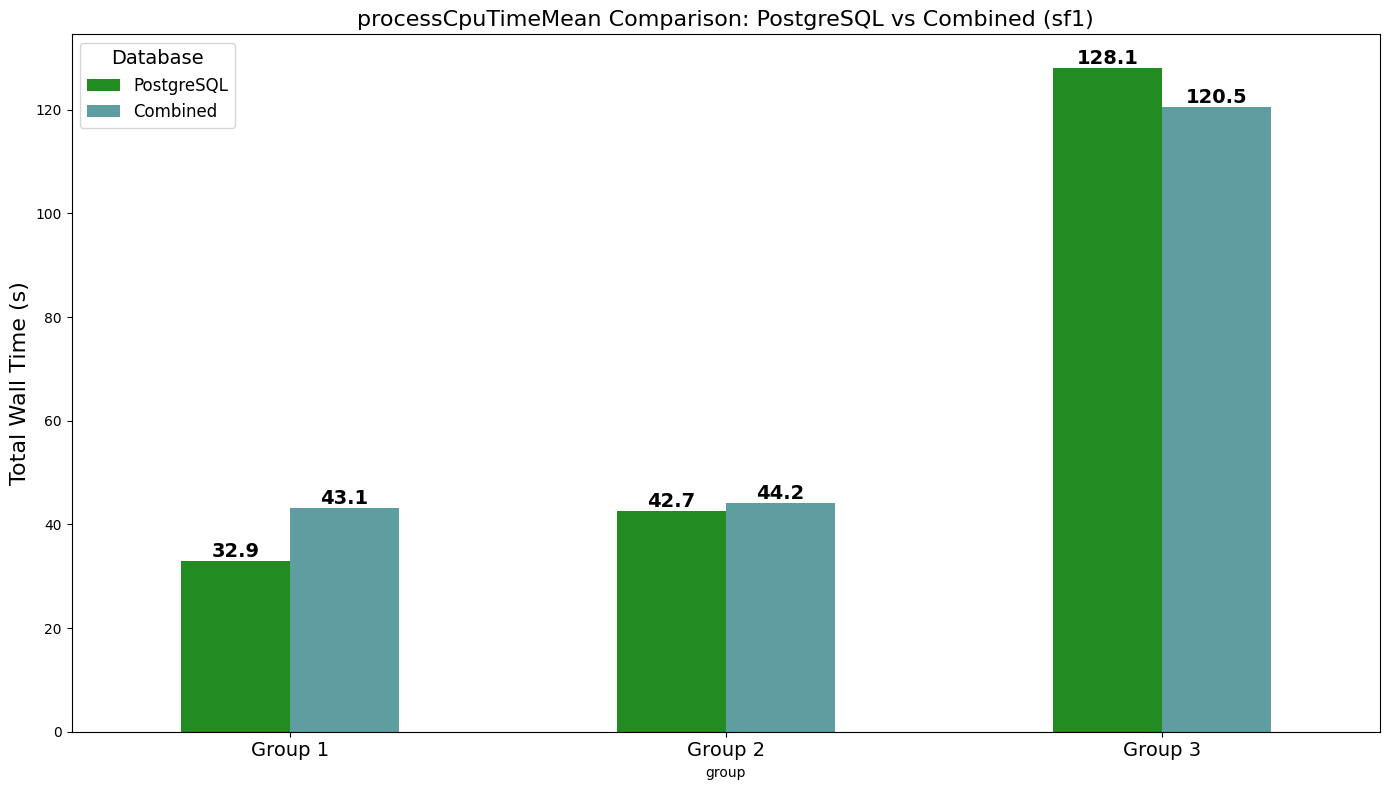

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
postgresql_file = '/content/tpcds_postgresql_sf1.txt'
combined_file = '/content/tpcds_combined_sf1_w1.txt'

# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read and process the data
data = pd.concat([
    pd.read_csv(postgresql_file, sep=r'\s+', names=columns, skiprows=1).assign(database="PostgreSQL"),
    pd.read_csv(combined_file, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined")
])

# Filter out failed queries and convert processCpuTimeMean to seconds
data = data[data['status'] == 'pass']
data["processCpuTimeMean"] = pd.to_numeric(data["processCpuTimeMean"], errors='coerce') / 1000

# Map queries to groups
group_mapping = {
    "Q1": "Group 1", "Q30": "Group 1", "Q15": "Group 1", "Q51": "Group 1", "Q65": "Group 1",
    "Q76": "Group 2", "Q94": "Group 2", "Q49": "Group 2", "Q35": "Group 2", "Q77": "Group 2",
    "Q5": "Group 3", "Q78": "Group 3", "Q21": "Group 3", "Q39": "Group 3"
}
data['group'] = data['query'].map(group_mapping)

# Group data by group and database, summing processCpuTimeMean
grouped_data = data.groupby(['group', 'database'], as_index=False)['processCpuTimeMean'].sum()

# Pivot the data to structure it for side-by-side bars
pivoted_data = grouped_data.pivot(index='group', columns='database', values='processCpuTimeMean').fillna(0)

# Plot the bars side by side
ax = pivoted_data[['PostgreSQL', 'Combined']].plot(kind="bar", figsize=(14, 8), color=["forestgreen", "cadetblue"])

# Add numerical labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
plt.title("processCpuTimeMean Comparison: PostgreSQL vs Combined (sf1)", fontsize=16)
plt.ylabel("Total Wall Time (s)", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=14)
plt.legend(title="Database", fontsize=12, title_fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

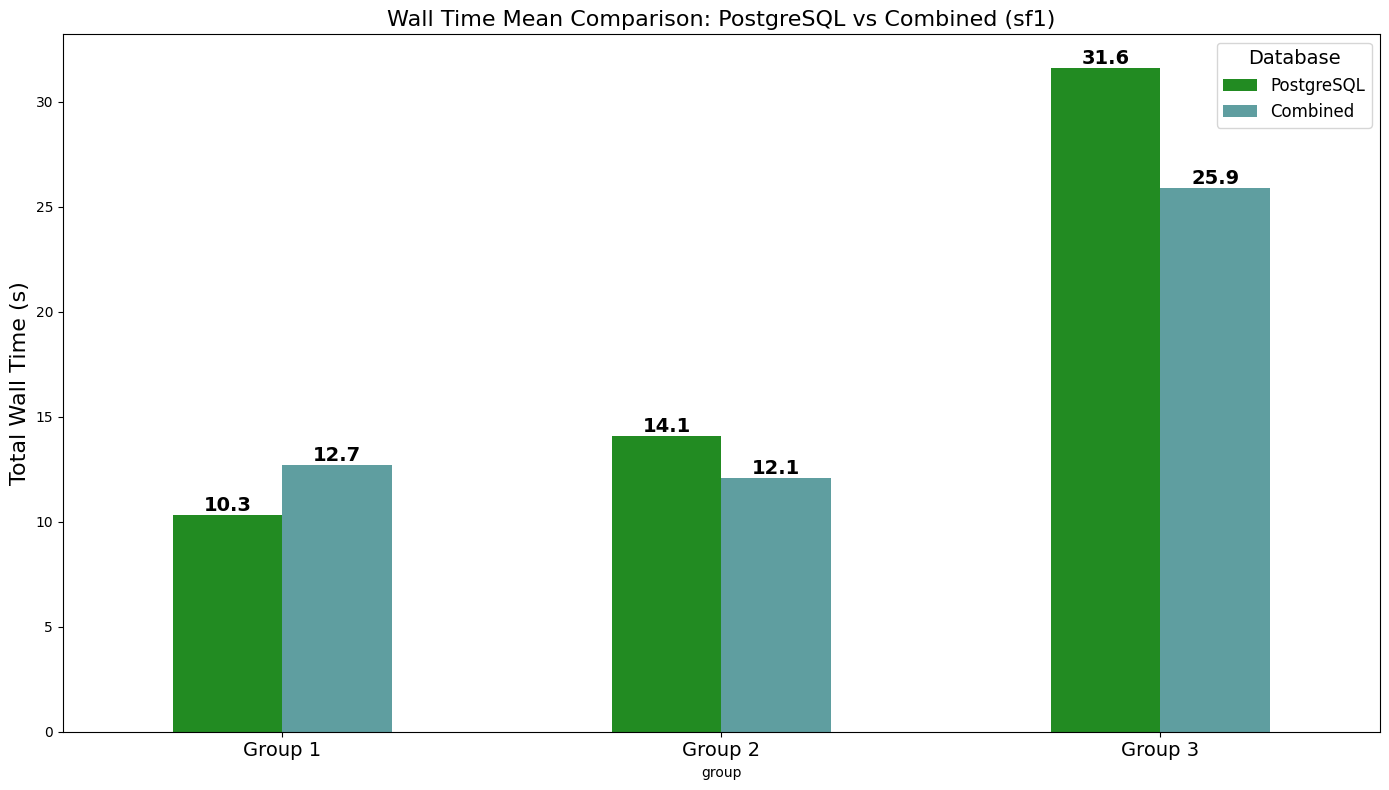

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
postgresql_file = '/content/tpcds_postgresql_sf1.txt'
combined_file = '/content/tpcds_combined_sf1_w1.txt'

# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read and process the data
data = pd.concat([
    pd.read_csv(postgresql_file, sep=r'\s+', names=columns, skiprows=1).assign(database="PostgreSQL"),
    pd.read_csv(combined_file, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined")
])

# Filter out failed queries and convert wallTimeMean to seconds
data = data[data['status'] == 'pass']
data["wallTimeMean"] = pd.to_numeric(data["wallTimeMean"], errors='coerce') / 1000

# Map queries to groups
group_mapping = {
    "Q1": "Group 1", "Q30": "Group 1", "Q15": "Group 1", "Q51": "Group 1", "Q65": "Group 1",
    "Q76": "Group 2", "Q94": "Group 2", "Q49": "Group 2", "Q35": "Group 2", "Q77": "Group 2",
    "Q5": "Group 3", "Q78": "Group 3", "Q21": "Group 3", "Q39": "Group 3"
}
data['group'] = data['query'].map(group_mapping)

# Group data by group and database, summing wallTimeMean
grouped_data = data.groupby(['group', 'database'], as_index=False)['wallTimeMean'].sum()

# Pivot the data to structure it for side-by-side bars
pivoted_data = grouped_data.pivot(index='group', columns='database', values='wallTimeMean').fillna(0)

# Plot the bars side by side
ax = pivoted_data[['PostgreSQL', 'Combined']].plot(kind="bar", figsize=(14, 8), color=["forestgreen", "cadetblue"])

# Add numerical labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
plt.title("Wall Time Mean Comparison: PostgreSQL vs Combined (sf1)", fontsize=16)
plt.ylabel("Total Wall Time (s)", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=14)
plt.legend(title="Database", fontsize=12, title_fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

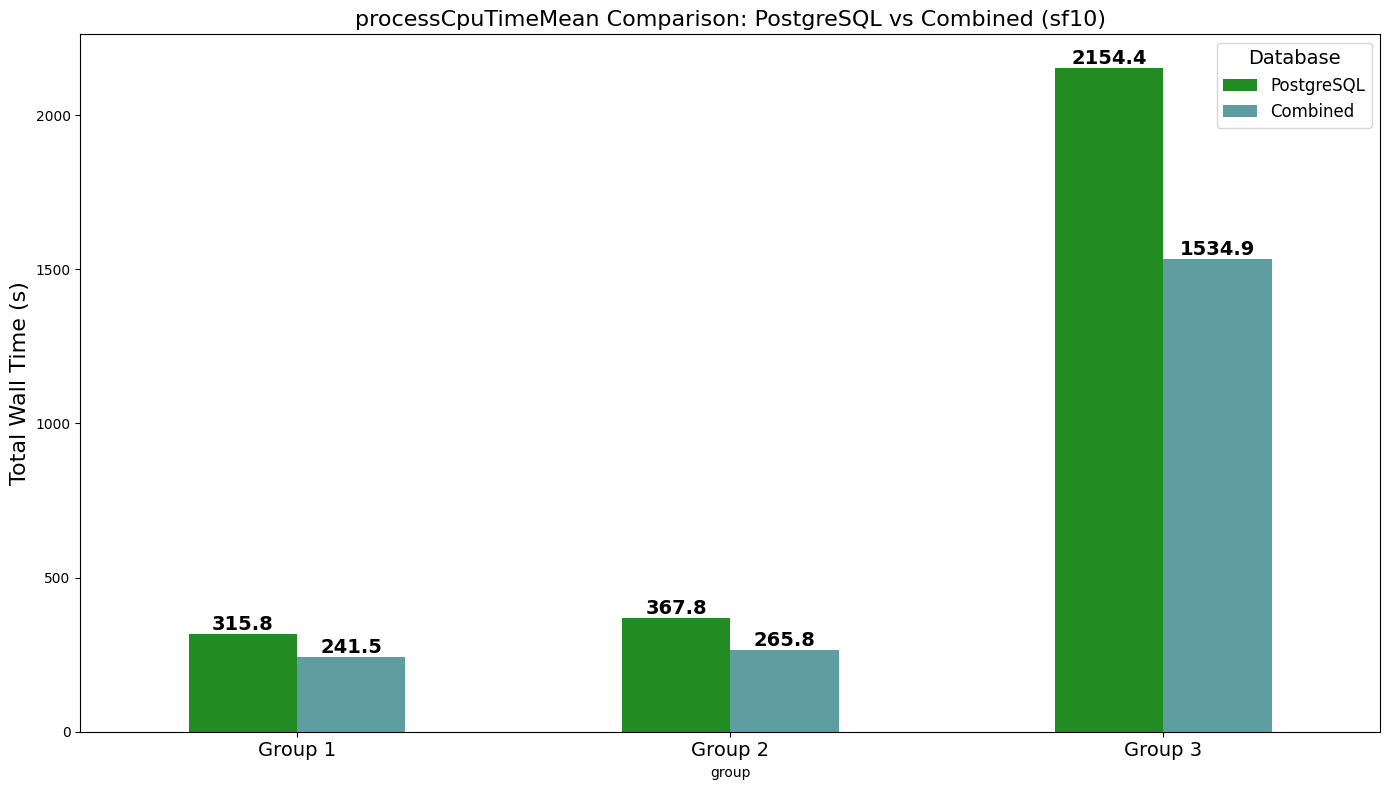

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
postgresql_file = '/content/tpcds_postgresql_sf10.txt'
combined_file = '/content/tpcds_combined_sf10_w1.txt'

# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read and process the data
data = pd.concat([
    pd.read_csv(postgresql_file, sep=r'\s+', names=columns, skiprows=1).assign(database="PostgreSQL"),
    pd.read_csv(combined_file, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined")
])

# Filter out failed queries and convert processCpuTimeMean to seconds
data = data[data['status'] == 'pass']
data["processCpuTimeMean"] = pd.to_numeric(data["processCpuTimeMean"], errors='coerce') / 1000

# Map queries to groups
group_mapping = {
    "Q1": "Group 1", "Q30": "Group 1", "Q15": "Group 1", "Q65": "Group 1",
    "Q76": "Group 2", "Q94": "Group 2", "Q49": "Group 2", "Q35": "Group 2", "Q77": "Group 2",
    "Q5": "Group 3", "Q78": "Group 3", "Q21": "Group 3", "Q39": "Group 3"
}
data['group'] = data['query'].map(group_mapping)

# Group data by group and database, summing processCpuTimeMean
grouped_data = data.groupby(['group', 'database'], as_index=False)['processCpuTimeMean'].sum()

# Pivot the data to structure it for side-by-side bars
pivoted_data = grouped_data.pivot(index='group', columns='database', values='processCpuTimeMean').fillna(0)

# Plot the bars side by side
ax = pivoted_data[['PostgreSQL', 'Combined']].plot(kind="bar", figsize=(14, 8), color=["forestgreen", "cadetblue"])

# Add numerical labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
plt.title("processCpuTimeMean Comparison: PostgreSQL vs Combined (sf10)", fontsize=16)
plt.ylabel("Total Wall Time (s)", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=14)
plt.legend(title="Database", fontsize=12, title_fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

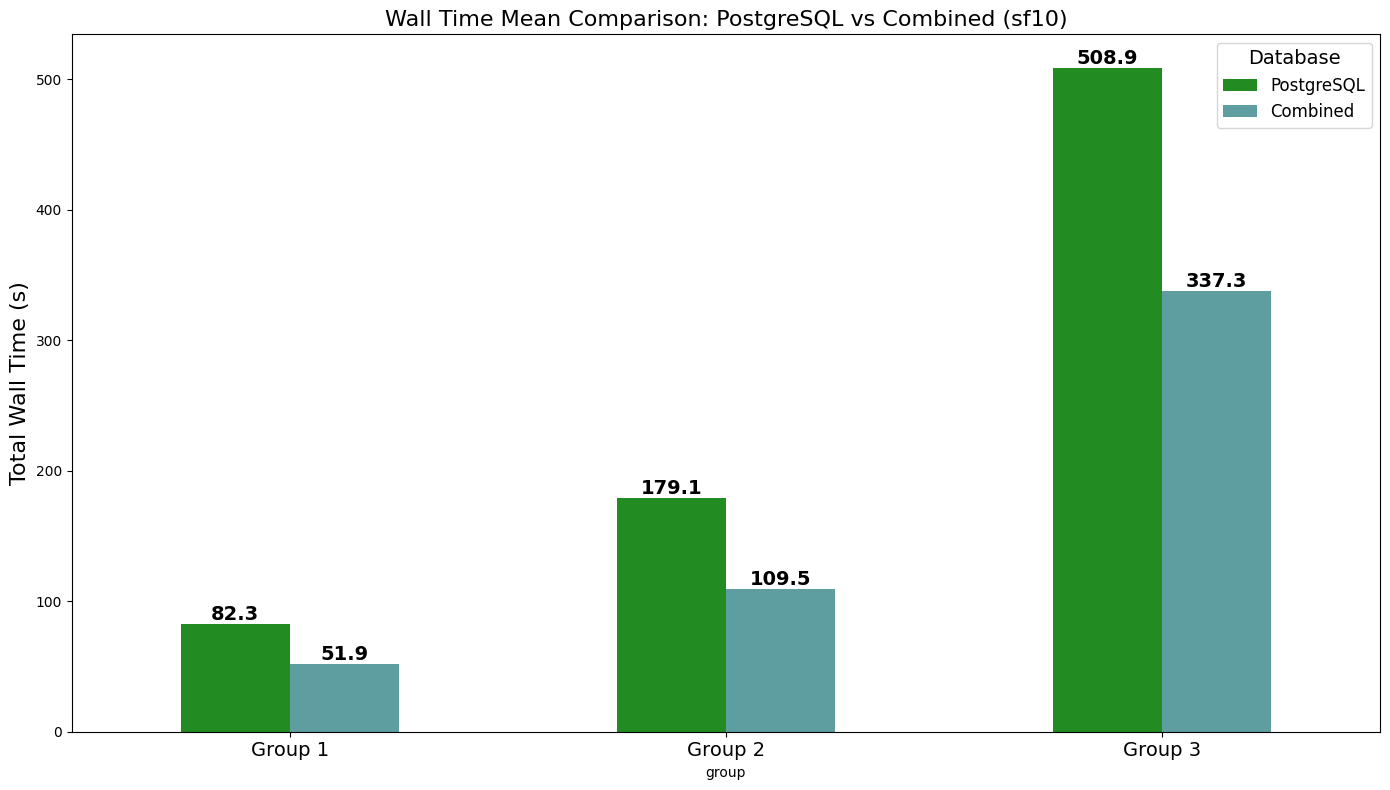

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
postgresql_file = '/content/tpcds_postgresql_sf10.txt'
combined_file = '/content/tpcds_combined_sf10_w1.txt'

# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read and process the data
data = pd.concat([
    pd.read_csv(postgresql_file, sep=r'\s+', names=columns, skiprows=1).assign(database="PostgreSQL"),
    pd.read_csv(combined_file, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined")
])

# Filter out failed queries and convert wallTimeMean to seconds
data = data[data['status'] == 'pass']
data["wallTimeMean"] = pd.to_numeric(data["wallTimeMean"], errors='coerce') / 1000

# Map queries to groups
group_mapping = {
    "Q1": "Group 1", "Q30": "Group 1", "Q15": "Group 1", "Q65": "Group 1",
    "Q76": "Group 2", "Q94": "Group 2", "Q49": "Group 2", "Q35": "Group 2", "Q77": "Group 2",
    "Q5": "Group 3", "Q78": "Group 3", "Q21": "Group 3", "Q39": "Group 3"
}
data['group'] = data['query'].map(group_mapping)

# Group data by group and database, summing wallTimeMean
grouped_data = data.groupby(['group', 'database'], as_index=False)['wallTimeMean'].sum()

# Pivot the data to structure it for side-by-side bars
pivoted_data = grouped_data.pivot(index='group', columns='database', values='wallTimeMean').fillna(0)

# Plot the bars side by side
ax = pivoted_data[['PostgreSQL', 'Combined']].plot(kind="bar", figsize=(14, 8), color=["forestgreen", "cadetblue"])

# Add numerical labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
plt.title("Wall Time Mean Comparison: PostgreSQL vs Combined (sf10)", fontsize=16)
plt.ylabel("Total Wall Time (s)", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=14)
plt.legend(title="Database", fontsize=12, title_fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

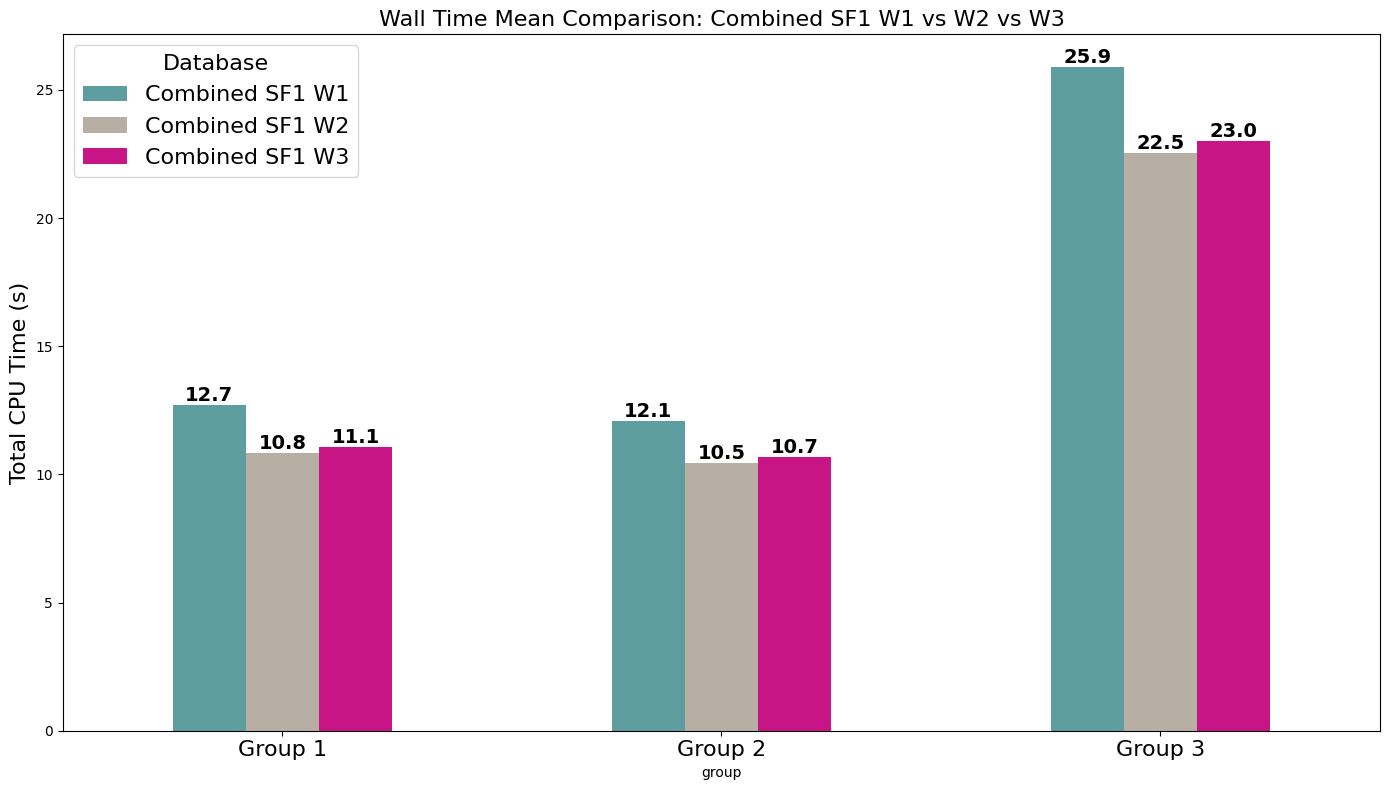

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
combined_sf1_w1 = '/content/tpcds_combined_sf1_w1.txt'
combined_sf1_w2 = '/content/tpcds_combined_sf1_w2.txt'
combined_sf1_w3 = '/content/tpcds_combined_sf1_w3.txt'


# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read and process the data
data = pd.concat([
    pd.read_csv(combined_sf1_w1, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined SF1 W1"),
    pd.read_csv(combined_sf1_w2, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined SF1 W2"),
    pd.read_csv(combined_sf1_w3, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined SF1 W3"),
])

# Filter out failed queries and convert wallTimeMean to seconds
data = data[data['status'] == 'pass']
data["wallTimeMean"] = pd.to_numeric(data["wallTimeMean"], errors='coerce') / 1000

# Map queries to groups
group_mapping = {
    "Q1": "Group 1", "Q30": "Group 1", "Q15": "Group 1", "Q65": "Group 1", "Q51": "Group 1",
    "Q76": "Group 2", "Q94": "Group 2", "Q49": "Group 2", "Q35": "Group 2", "Q77": "Group 2",
    "Q5": "Group 3", "Q78": "Group 3", "Q21": "Group 3", "Q39": "Group 3"
}
data['group'] = data['query'].map(group_mapping)

# Group data by group and database, summing wallTimeMean
grouped_data = data.groupby(['group', 'database'], as_index=False)['wallTimeMean'].sum()

# Pivot the data to structure it for side-by-side bars
pivoted_data = grouped_data.pivot(index='group', columns='database', values='wallTimeMean').fillna(0)

# Define custom colors
custom_colors = {
    "Combined SF1 W1": "cadetblue",
    "Combined SF1 W2": "#B7AFA3",
    "Combined SF1 W3": "mediumvioletred"
}

# Plot the bars side by side with custom colors
ax = pivoted_data.plot(kind="bar", figsize=(14, 8), color=[custom_colors[col] for col in pivoted_data.columns])

# Add numerical labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
plt.title("Wall Time Mean Comparison: Combined SF1 W1 vs W2 vs W3", fontsize=16)
plt.ylabel("Total CPU Time (s)", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=16)
plt.legend(title="Database", fontsize=16, title_fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

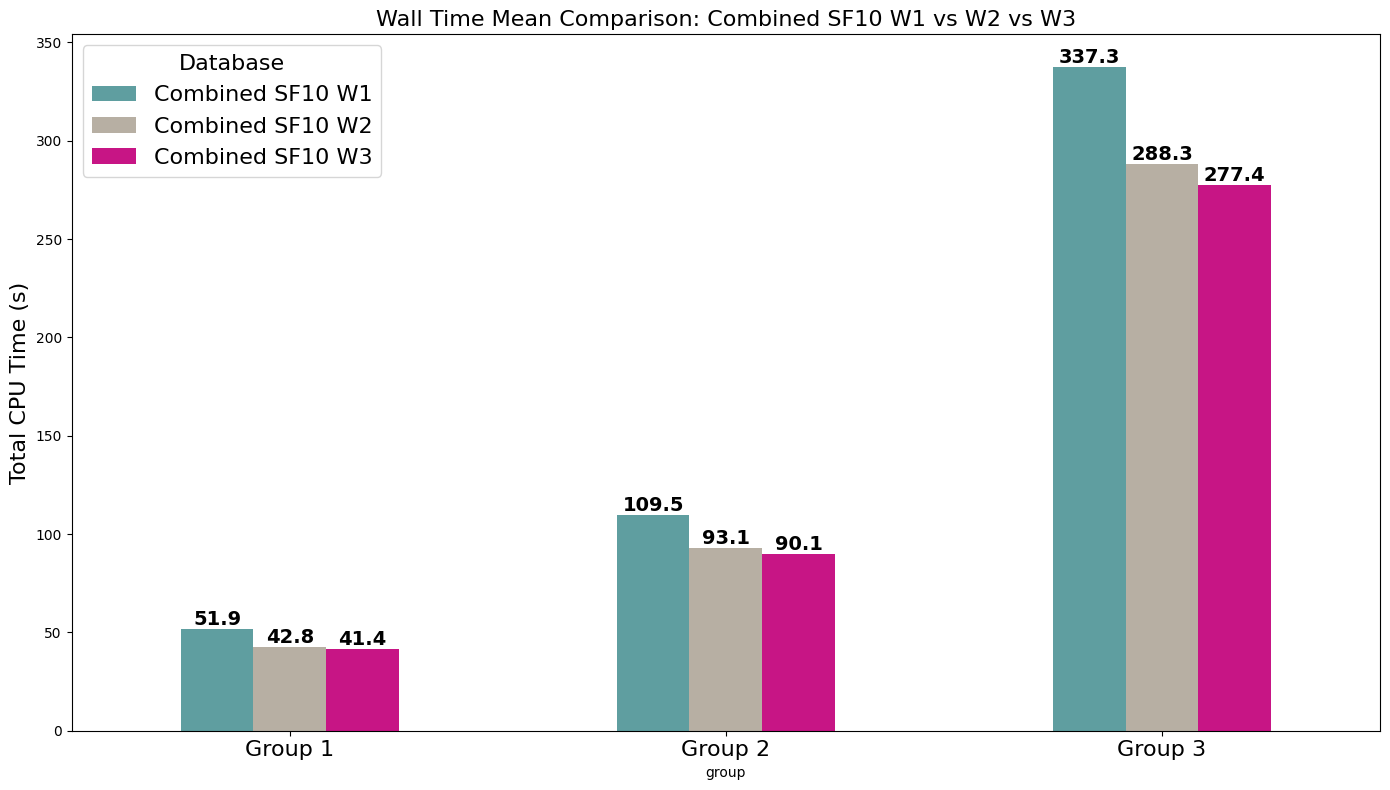

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
combined_sf10_w1 = '/content/tpcds_combined_sf10_w1.txt'
combined_sf10_w2 = '/content/tpcds_combined_sf10_w2.txt'
combined_sf10_w3 = '/content/tpcds_combined_sf10_w3.txt'

# Define column names
columns = [
    "suite", "query", "wallTimeP50", "wallTimeMean", "wallTimeStd",
    "processCpuTimeP50", "processCpuTimeMean", "processCpuTimeStd",
    "queryCpuTimeP50", "queryCpuTimeMean", "queryCpuTimeStd", "status", "error"
]

# Read and process the data
data = pd.concat([
    pd.read_csv(combined_sf10_w1, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined SF10 W1"),
    pd.read_csv(combined_sf10_w2, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined SF10 W2"),
    pd.read_csv(combined_sf10_w3, sep=r'\s+', names=columns, skiprows=1).assign(database="Combined SF10 W3"),
])

# Filter out failed queries and convert wallTimeMean to seconds
data = data[data['status'] == 'pass']
data["wallTimeMean"] = pd.to_numeric(data["wallTimeMean"], errors='coerce') / 1000

# Map queries to groups
group_mapping = {
    "Q1": "Group 1", "Q30": "Group 1", "Q15": "Group 1", "Q65": "Group 1", #"Q51": "Group 1",
    "Q76": "Group 2", "Q94": "Group 2", "Q49": "Group 2", "Q35": "Group 2", "Q77": "Group 2",
    "Q5": "Group 3", "Q78": "Group 3", "Q21": "Group 3", "Q39": "Group 3"
}
data['group'] = data['query'].map(group_mapping)

# Group data by group and database, summing wallTimeMean
grouped_data = data.groupby(['group', 'database'], as_index=False)['wallTimeMean'].sum()

# Pivot the data to structure it for side-by-side bars
pivoted_data = grouped_data.pivot(index='group', columns='database', values='wallTimeMean').fillna(0)

# Define custom colors
custom_colors = {
    "Combined SF10 W1": "cadetblue",
    "Combined SF10 W2": "#B7AFA3",
    "Combined SF10 W3": "mediumvioletred"
}

# Plot the bars side by side with custom colors
ax = pivoted_data.plot(kind="bar", figsize=(14, 8), color=[custom_colors[col] for col in pivoted_data.columns])

# Add numerical labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
plt.title("Wall Time Mean Comparison: Combined SF10 W1 vs W2 vs W3", fontsize=16)
plt.ylabel("Total CPU Time (s)", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=16)
plt.legend(title="Database", fontsize=16, title_fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()